# exogeneous case

Try the below situations. Both of them are observable heterogeneity. And not high dimensional case.

Under RCT

1. $y_i = x_i^{'} \beta + \gamma d_i + \epsilon_i$, homogeneous treatment effects
2. $y_i = x_i^{'} \beta + cross(d_i, x_i)^{'} \gamma + \epsilon_i$, heterogeneous treatment effects by the observable variables
3. $y_i = x_i^{'} \beta + \gamma d_i + cross(d_i, w_i)^{'} \delta + \epsilon_i$, heterogeneous treatment effects by the unobservable variables

$x_i = (1,\ z_i)^{'}$ where $z_i \sim N(0,1)$. And $w_i$ can not be ovserved. I try the two cases where $Cov(x_i, w_i) \neq 0$. This means $x_i$ is the proxy for $w_i$. So the cross term is replaced by $cross(d_i, x_i)$ in estimation.


わかったこと
- 真のmodelを$ITE = 1 + \frac{1}{2} z_i$のように完全に正しく特定したregressionは強い
- ヘテロがある状況でヘテロを考えないで回帰すると当然regressionは無力
- NNならヘテロがあるかどうかわからなくても、変数をそのまま入れて学習させることで予測値の差がindividual treatment effectに近くなる
- 観測できない異質性が存在し、その代理変数を用いることのできる場合においてNNがregressionに対して有利というわけではない

In [2]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

## specification 1
$\beta = (1,-1)^{'}, \gamma = 1$

In [72]:
# data generation
np.random.seed(0)
sample_size = 100000
half_size = int(sample_size/2)
z = np.random.normal(size = (sample_size,1))
d1 = np.ones((half_size,1))
d0 = np.zeros((half_size,1))
d = np.vstack((d0,d1))
const = np.ones((sample_size,1))
x = np.hstack((np.hstack((const, z)), d))
y = 1 + -z + d + np.random.normal(scale = 0.5, size = (sample_size,1))

# make counter X
d1_counter = np.zeros((half_size,1))
d0_counter = np.ones((half_size,1))
d_counter = np.vstack((d0_counter, d1_counter))
x_counter = np.hstack((np.hstack((const, z)), d_counter))

### regression

In [5]:
# regression
regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(x, y)

# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[ 0.99711691 -0.99813625  1.00582469]]


### neural nets

In [6]:
# neural nets
nn = MLPRegressor(hidden_layer_sizes=(10, ))
nn.fit(x, y)

/Users/keiikegami/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [19]:
# effect prediction on training sample
effec_on_nontreat = nn.predict(x_counter)[0:half_size] - nn.predict(x)[0:half_size]
effec_on_treat = nn.predict(x)[half_size:] - nn.predict(x_counter)[half_size:]

In [22]:
np.mean(effec_on_nontreat)

1.0076118531667566

In [23]:
np.mean(effec_on_treat)

1.0076121247729286

In [29]:
np.var(effec_on_nontreat)

0.0003308498320210379

In [30]:
np.var(effec_on_treat)

0.00032470210288134484

In [27]:
# effect on new samples
z_new = np.random.normal(size = (sample_size,1))

x_new1 = np.hstack((np.hstack((const, z_new)), np.ones((sample_size,1))))
x_new0 = np.hstack((np.hstack((const, z_new)), np.zeros((sample_size,1))))

effect_on_newsample = nn.predict(x_new1) - nn.predict(x_new0)

In [28]:
np.mean(effect_on_newsample)

1.0075487018840896

In [31]:
np.var(effect_on_newsample)

0.00033511288999682454

### specification 2

This specification include the cross terms in the true model. 

$y_i = 1 - z_i + d_i + \frac{1}{2}z_i d_i + \epsilon_i$

So the treatment effect on the person whose $Z = z_i$ is $1+\frac{1}{2}z_i$.

In [97]:
# data generation
np.random.seed(0)
sample_size = 100000
half_size = int(sample_size/2)
z = np.random.normal(size = (sample_size,1))
d1 = np.ones((half_size,1))
d0 = np.zeros((half_size,1))
d = np.vstack((d0,d1))
cross = np.multiply(z, d)
const = np.ones((sample_size,1))
x_origin = np.hstack((np.hstack((const, z)), d))
x = np.hstack((np.hstack((np.hstack((const, z)), d)), cross))
y = 1 + -z + d + 1/2*cross + np.random.normal(scale = 0.5, size = (sample_size,1))

# make counter X
d1_counter = np.zeros((half_size,1))
d0_counter = np.ones((half_size,1))
d_counter = np.vstack((d0_counter, d1_counter))
cross_counter = np.multiply(z, d_counter)
x_counter_origin = np.hstack((np.hstack((const, z)), d_counter))
x_counter = np.hstack((np.hstack((np.hstack((const, z)), d_counter)), cross_counter))

### regression

In [86]:
# regression
regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(x, y)

# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[ 1.00535582 -1.00286055  0.99434548  0.50649793]]


In [87]:
# the estimated individual treatment effects
estimated_ITE = [regr.coef_[0][2] + regr.coef_[0][3]*i[0] for i in z]
true_ITE = [1 + 1/2*i[0] for i in z]

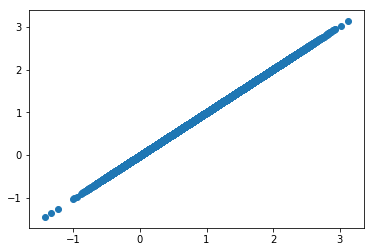

In [88]:
plt.scatter(true_ITE, estimated_ITE)

In [89]:
# distance
diff = np.subtract(true_ITE, estimated_ITE)
dist_reg = np.sqrt(np.sum([i**2 for i in diff]))
dist_reg

2.7176581774539823

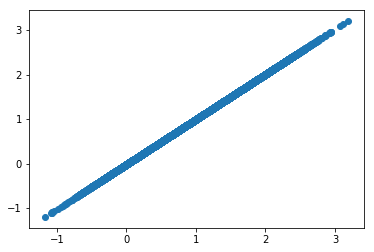

In [91]:
# effect on new sample
z_new = np.random.normal(size = (sample_size,1))
true_ITE_newsample = [1 + 1/2 * i[0] for i in z_new]
estimated_ITE_newsamplereg = [regr.coef_[0][2] + regr.coef_[0][3]*i[0] for i in z_new]
plt.scatter(true_ITE_newsample, estimated_ITE_newsamplereg)

In [93]:
diff = np.subtract(true_ITE_newsample, estimated_ITE_newsamplereg)
dist_reg2 = np.sqrt(np.sum([i**2 for i in diff]))
dist_reg2

2.714807658272234

In [123]:
# misspecificationを考える（nnではactivationによってcrossを明示的に入れなくてもうまくいくので）
# crossを入れ損ねるケース
# heteroをやる余地がないのでそりゃ当然だめ
regr2 = linear_model.LinearRegression(fit_intercept=False)
regr2.fit(x_origin, y)

# The coefficients
print('Coefficients: \n', regr2.coef_)

Coefficients: 
 [[ 1.00631794 -0.74927062  0.99514041]]


### neural nets

In [115]:
# neural nets
# layerは2みたいに少なすぎるとダメ
# 10がちょうどいい
# 100とかデカ過ぎてもダメ
# activationでも結構変わる。identity、reluは良い。logistic, tanhはダメ
nn = MLPRegressor(hidden_layer_sizes=(10, ), activation='relu')
nn.fit(x, y)

/Users/keiikegami/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [116]:
# effect prediction on training sample 1
effec_on_nontreat = nn.predict(x_counter)[0:half_size] - nn.predict(x)[0:half_size]
effec_on_treat = nn.predict(x)[half_size:] - nn.predict(x_counter)[half_size:]

In [117]:
ITE_on_sample = np.hstack((effec_on_nontreat, effec_on_treat))

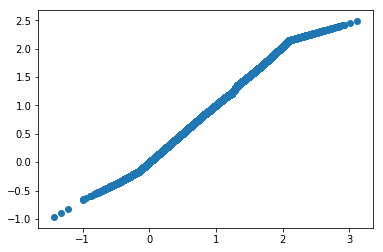

In [118]:
plt.scatter(true_ITE, ITE_on_sample)

In [114]:
diff_nn = np.subtract(ITE_on_sample, true_ITE)
dist_nn = np.sqrt(np.sum([i**2 for i in diff_nn]))
dist_nn

12.01820980362247

In [119]:
# effect prediction on training sample 2
# こっちの方が悪くなるの意外?
effec_on_nontreat2 = nn.predict(x_counter)[0:half_size] - y[0:half_size].T
effec_on_treat2 = y[half_size:].T - nn.predict(x_counter)[half_size:]
ITE_on_sample2 = np.hstack((effec_on_nontreat2, effec_on_treat2))
diff_nn2 = np.subtract(ITE_on_sample2, true_ITE)
dist_nn2 = np.sqrt(np.sum([i**2 for i in diff_nn2]))
dist_nn2

158.108887632532

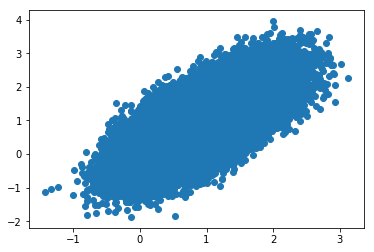

In [120]:
plt.scatter(true_ITE, ITE_on_sample2)

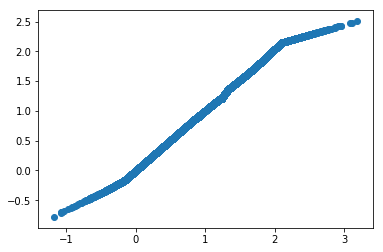

In [121]:
# effect on new sample

x_new1 = np.hstack((np.hstack((np.hstack((const, z_new)), np.ones((sample_size,1)))), z_new))
x_new0 = np.hstack((np.hstack((np.hstack((const, z_new)), np.zeros((sample_size,1)))), np.zeros((sample_size,1))))

ITE_on_newsample_nn = nn.predict(x_new1) - nn.predict(x_new0)

plt.scatter(true_ITE_newsample, ITE_on_newsample_nn)

In [122]:
diff_nn2 = np.subtract(true_ITE_newsample, ITE_on_newsample_nn)
dist_nn2 = np.sqrt(np.sum([i**2 for i in diff_nn2]))
dist_nn2

6.959580814983664

/Users/keiikegami/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


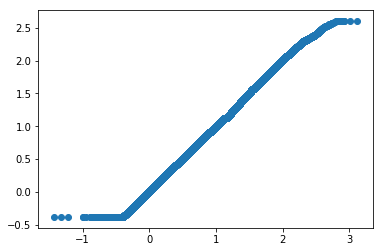

In [124]:
# nnならxにcrossを入れなくてもいける？
# x_originを使って同じことする。
# activationがidentityだとダメだけど、reluとかなら改善する
# これは一つ嬉しい
nn2 = MLPRegressor(hidden_layer_sizes=(10, ), activation='relu')
nn2.fit(x_origin, y)
effec_on_nontreat_origin = nn2.predict(x_counter_origin)[0:half_size] - nn2.predict(x_origin)[0:half_size]
effec_on_treat_origin = nn2.predict(x_origin)[half_size:] - nn2.predict(x_counter_origin)[half_size:]
ITE_on_sample_origin = np.hstack((effec_on_nontreat_origin, effec_on_treat_origin))
plt.scatter(true_ITE, ITE_on_sample_origin)

In [125]:
diff_nn2 = np.subtract(ITE_on_sample_origin, true_ITE)
dist_nn2 = np.sqrt(np.sum([i**2 for i in diff_nn2]))
dist_nn2

5.639766706396585

/Users/keiikegami/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


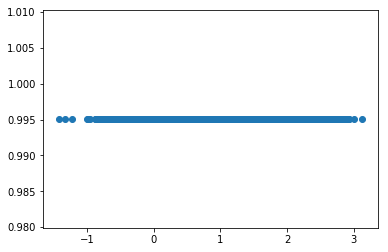

In [126]:
# identity version
nn3 = MLPRegressor(hidden_layer_sizes=(10, ), activation='identity')
nn3.fit(x_origin, y)
effec_on_nontreat_origin = nn3.predict(x_counter_origin)[0:half_size] - nn3.predict(x_origin)[0:half_size]
effec_on_treat_origin = nn3.predict(x_origin)[half_size:] - nn3.predict(x_counter_origin)[half_size:]
ITE_on_sample_origin = np.hstack((effec_on_nontreat_origin, effec_on_treat_origin))
plt.scatter(true_ITE, ITE_on_sample_origin)

In [127]:
diff_nn2 = np.subtract(ITE_on_sample_origin, true_ITE)
dist_nn2 = np.sqrt(np.sum([i**2 for i in diff_nn2]))
dist_nn2

157.70363257116617

## specification 3

This specification include the cross terms in the true model. 

$y_i = 1 - w_i + d_i + \frac{1}{2}w_i d_i + \epsilon_i$

So the individual treatment effect on the person whose $W = w_i$ is $1+\frac{1}{2}w_i$.

But we cannot observe $w_i$ and so use $z_i$ as the proxy. 

In [56]:
# data generation
np.random.seed(0)
sample_size = 100000
half_size = int(sample_size/2)
covariance = 0.9

d1 = np.ones((half_size,1))
d0 = np.zeros((half_size,1))
d = np.vstack((d0,d1))

const = np.ones((sample_size,1))

covariate = np.random.multivariate_normal(mean = [0,0], cov = [[1, covariance],[covariance, 1]], size = sample_size)

z = np.reshape(covariate[:, 0], (sample_size, 1))
w = np.reshape(covariate[:, 1], (sample_size, 1))

cross = np.multiply(z, d)
true_cross = np.multiply(w, d)

x = np.hstack((np.hstack((np.hstack((const, z)), d)), cross))

y = 1 + -w + d + 1/2*true_cross + np.random.normal(scale = 0.5, size = (sample_size,1))

# make counter X
d1_counter = np.zeros((half_size,1))
d0_counter = np.ones((half_size,1))
d_counter = np.vstack((d0_counter, d1_counter))
cross_counter = np.multiply(z, d_counter)
x_counter = np.hstack((np.hstack((np.hstack((const, z)), d_counter)), cross_counter))

### regression

In [57]:
# regression
regr3 = linear_model.LinearRegression(fit_intercept=False)
regr3.fit(x, y)

# The coefficients
print('Coefficients: \n', regr3.coef_)

Coefficients: 
 [[ 0.99524392 -0.90515608  1.00358589  0.45642897]]


In [58]:
# the estimated individual treatment effects
estimated_ITE = [regr3.coef_[0][2] + regr3.coef_[0][3]*i[0] for i in z]
true_ITE = [1 + 1/2*i[0] for i in w]

In [59]:
# distance
diff = np.subtract(true_ITE, estimated_ITE)
dist_reg = np.sqrt(np.sum([i**2 for i in diff]))
dist_reg

68.7619806769933

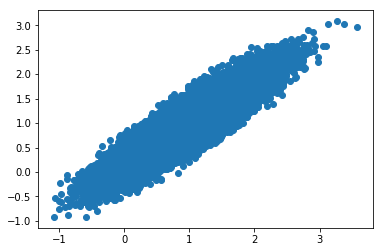

In [60]:
plt.scatter(true_ITE, estimated_ITE)

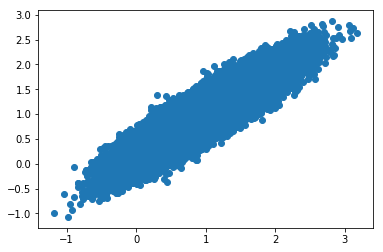

In [61]:
# new sample
covariate_new = np.random.multivariate_normal(mean = [0,0], cov = [[1, covariance],[covariance, 1]], size = sample_size)

z_new = np.reshape(covariate_new[:, 0], (sample_size, 1))
w_new = np.reshape(covariate_new[:, 1], (sample_size, 1))

true_ITE_newsample = [1 + 1/2 * i[0] for i in w_new]
estimated_ITE_newsamplereg = [regr3.coef_[0][2] + regr3.coef_[0][3]*i[0] for i in z_new]
plt.scatter(true_ITE_newsample, estimated_ITE_newsamplereg)

In [62]:
diff = np.subtract(true_ITE_newsample, estimated_ITE_newsamplereg)
dist_reg2 = np.sqrt(np.sum([i**2 for i in diff]))
dist_reg2

68.92579114442967

### neural nets

In [71]:
nn = MLPRegressor(hidden_layer_sizes=(50, ), activation='relu')
nn.fit(x, y)
# effect prediction on training sample 1
effec_on_nontreat = nn.predict(x_counter)[0:half_size] - nn.predict(x)[0:half_size]
effec_on_treat = nn.predict(x)[half_size:] - nn.predict(x_counter)[half_size:]
ITE_on_sample = np.hstack((effec_on_nontreat, effec_on_treat))


/Users/keiikegami/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [72]:
diff_nn = np.subtract(ITE_on_sample, true_ITE)
dist_nn = np.sqrt(np.sum([i**2 for i in diff_nn]))
dist_nn

69.20965377536871

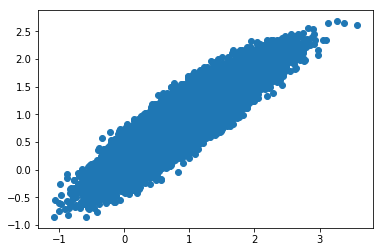

In [73]:
plt.scatter(true_ITE, ITE_on_sample)

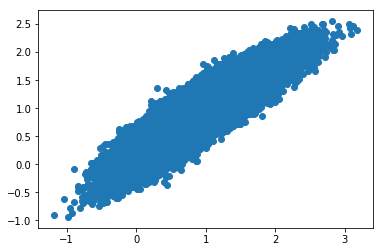

In [74]:
# effect on new sample
x_new1 = np.hstack((np.hstack((np.hstack((const, z_new)), np.ones((sample_size,1)))), z_new))
x_new0 = np.hstack((np.hstack((np.hstack((const, z_new)), np.zeros((sample_size,1)))), np.zeros((sample_size,1))))

ITE_on_newsample_nn = nn.predict(x_new1) - nn.predict(x_new0)

plt.scatter(true_ITE_newsample, ITE_on_newsample_nn)

In [75]:
diff_nn2 = np.subtract(true_ITE_newsample, ITE_on_newsample_nn)
dist_nn2 = np.sqrt(np.sum([i**2 for i in diff_nn2]))
dist_nn2

69.40028674603751